 ### Using Pythong Skforecast

In [266]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [246]:
from sklearn.linear_model import Ridge, Lasso
# from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.impute import KNNImputer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [189]:
data = pd.read_csv("./scraping/california/california_full_data_hourly_20200101_20211231.csv")

In [190]:
# Extreme value deletion (definitly outlier)
data.at[data[data.Wind < -100].index.tolist()[0], 'Wind'] = 0

In [191]:
# Impute NA Values
raw = data.drop(columns=['date_time_hourly'])
imputer = KNNImputer(n_neighbors=3, weights="uniform")
imputed_data = imputer.fit_transform(raw)
data = pd.DataFrame(imputed_data, columns=raw.columns)

In [306]:
data.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Batteries,Imports,Other,Natural Gas,Large Hydro,tempC,uvIndex,WindGustKmph,cloudcover,humidity,precipMM
0,-33.000000,797.833333,650.083333,299.750000,229.500000,210.416667,9.916667,2273.333333,1.666667,8321.750000,0.0,8247.666667,1345.583333,6.0,3.0,4.0,7.0,59.0,0.0
1,-33.666667,986.750000,648.083333,302.416667,231.000000,209.750000,8.250000,2272.666667,-2.500000,7684.833333,0.0,8072.500000,1230.416667,6.0,3.0,4.0,8.0,59.0,0.0
2,-34.000000,1036.416667,645.916667,304.500000,230.416667,210.750000,8.666667,2273.333333,-0.750000,7835.666667,0.0,7311.500000,1176.583333,5.0,3.0,4.0,9.0,59.0,0.0
3,-35.083333,920.250000,644.166667,301.166667,231.083333,209.750000,8.750000,2273.333333,-0.916667,7857.333333,0.0,7037.833333,1192.916667,5.0,3.0,4.0,10.0,59.0,0.0
4,-35.000000,1288.750000,643.916667,302.083333,232.000000,209.416667,9.583333,2271.750000,6.083333,7791.416667,0.0,6526.166667,1241.000000,5.0,3.0,6.0,11.0,58.0,0.0


In [192]:
end_train = 12280
end_val = 15790

train = data.loc[:end_train, :]
val = data.loc[end_train + 1:end_val, :]
test = data.loc[end_val+1:, :]

In [193]:
# make Time series plot
def make_time_series(feature):
    fig, ax = plt.subplots(figsize=(12, 4))
    train[feature].plot(ax=ax, label='train', linewidth=1)
    val[feature].plot(ax=ax, label='validation', linewidth=1)
    test[feature].plot(ax=ax, label='test', linewidth=1)
    ax.set_title(f'{feature} Production')
    ax.legend()

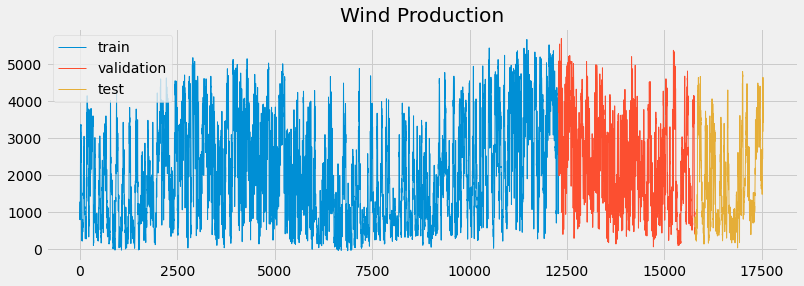

In [194]:
make_time_series("Wind")

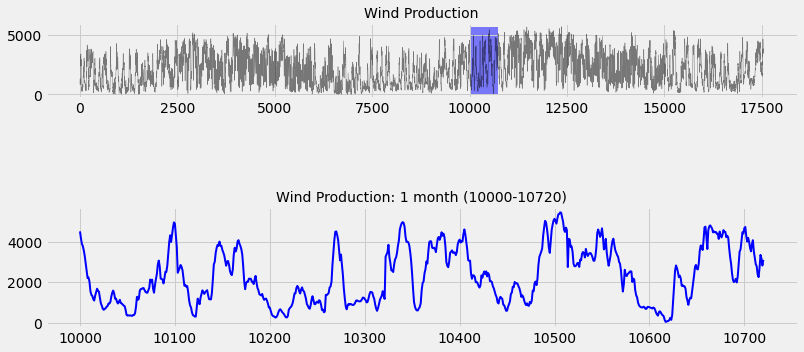

In [285]:
fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data.Wind.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Wind)
max_y = max(data.Wind)
main_ax.fill_between((10000, 10720), min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

data.loc[10000: 10720].Wind.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Wind Production', fontsize=14)
zoom_ax.set_title(f'Wind Production: 1 month (10000-10720)', fontsize=14)
plt.subplots_adjust(hspace=1)

### Training

In [264]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 60
             )

In [269]:
# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

# Lags used as predictors
lags_grid = [5, 30, [1, 2, 3, 7, 28, 29, 30, 31, 8759, 8760, 8761]]

best = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:end_val, 'Wind'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(data[:end_train]),
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:09<00:00,  3.04s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'ridge__alpha': 0.001}
  Backtesting metric: 637.6528897591455



In [270]:
best

,lags,params,metric,ridge__alpha
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.001},637.652890,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.007742636826811269},637.654192,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.05994842503189409},637.664268,0.059948
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.46415888336127775},637.741896,0.464159
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 3.593813663804626},638.315948,3.593814
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 27.825594022071257},642.199533,27.825594
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 215.44346900318823},659.159655,215.443469
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 1668.1005372000557},706.996902,1668.100537
20,"[1, 2, 3, 7, 28, 29, 30, 31, 8759, 8760, 8761]",{'ridge__alpha': 0.001},790.518561,0.001000
21,"[1, 2, 3, 7, 28, 29, 30, 31, 8759, 8760, 8761]",{'ridge__alpha': 0.007742636826811269},790.521654,0.007743


In [275]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data.Wind,
                            initial_train_size = len(train.Wind),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit = False,
                            verbose    = False
                        )

In [240]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=42),
                lags      = 12 # This value will be replaced in the grid search
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 200, 500],
              'max_depth': [3, 5, 10]}

# Lags used as predictors
lags_grid = [3, 10, 20]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train.Wind[:end_train],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 5,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)//2),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 27


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [18:44<00:00, 374.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 647486.6992286328



In [277]:
steps = 36
forecaster2 = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=42)),
                    steps     = steps,
                    lags      = 8
                )
forecaster2.fit(y=train.Wind)

In [278]:
predictions = predictions[:len(val)]
predictions.head()

,pred
12281,3398.345535
12282,3490.398228
12283,3539.175241
12284,3545.054223
12285,3521.451254


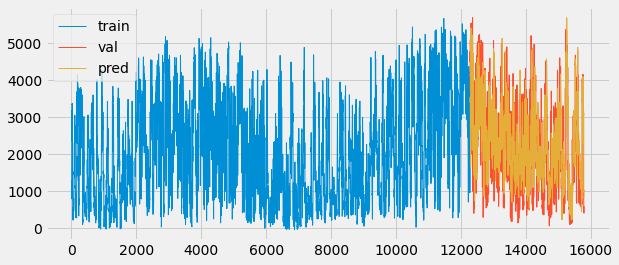

In [304]:
fig, ax = plt.subplots(figsize=(9, 4))
train.Wind.plot(ax=ax, label='train', linewidth=1)
val.Wind.plot(ax=ax, label='val', linewidth=1)
predictions.plot(ax=ax, label='pred', linewidth=1)
ax.legend()

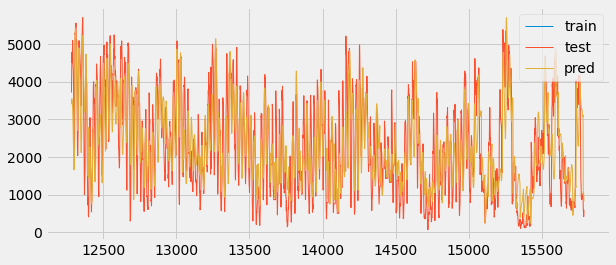

In [283]:
fig, ax = plt.subplots(figsize=(9, 4))
train.Wind[len(train):].plot(ax=ax, label='train', linewidth=1)
val.Wind.plot(ax=ax, label='test', linewidth=1)
predictions.plot(ax=ax, label='pred', linewidth=1)
ax.legend()

In [284]:
# Error
error = mean_absolute_error(val.Wind, y_pred = predictions)
error_mse = mean_squared_error(val.Wind, y_pred = predictions)
print(f"Val Error: {error}, MSE error : {error_mse}")

Val Error: 617.3308206912169, MSE error : 624919.2252666908


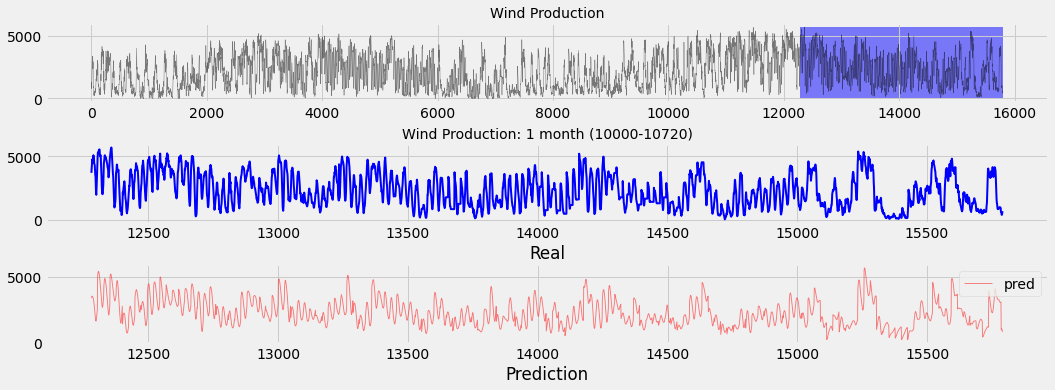

In [303]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(nrows=12, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:4, :])
zoom_ax = fig.add_subplot(grid[5:8, :])
preds_ax = fig.add_subplot(grid[9:, :])

data.Wind[:len(train) + len(val)].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
predictions.plot(ax=preds_ax, c='red', alpha=0.5, linewidth=0.9)
min_y = min(data.Wind)
max_y = max(data.Wind)
main_ax.fill_between((len(train), len(train) + len(val)), min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
zoom_ax.set_xlabel('Real')
preds_ax.set_xlabel('Prediction')
data.loc[len(train): len(train) + len(val)].Wind.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Wind Production', fontsize=14)
zoom_ax.set_title(f'Wind Production: 1 month (10000-10720)', fontsize=14)
plt.subplots_adjust(hspace=1)

In [308]:
steps = 36
forecaster2 = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=42)),
                    steps     = steps,
                    lags      = 8
                )
# forecaster2.fit(y=train.Solar)

/Users/g/.pyenv/versions/3.10.0/envs/cs329/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.361e+07, tolerance: 2.310e+07
  model = cd_fast.enet_coordinate_descent(
/Users/g/.pyenv/versions/3.10.0/envs/cs329/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.096e+08, tolerance: 2.310e+07
  model = cd_fast.enet_coordinate_descent(
/Users/g/.pyenv/versions/3.10.0/envs/cs329/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

In [311]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster2,
                            y          = data.Solar,
                            initial_train_size = len(train.Solar) + len(val.Solar),
                            steps      = 36,
                            metric     = 'mean_absolute_error',
                            refit = False,
                            verbose    = False
                        )

/Users/g/.pyenv/versions/3.10.0/envs/cs329/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e+07, tolerance: 3.241e+07
  model = cd_fast.enet_coordinate_descent(
/Users/g/.pyenv/versions/3.10.0/envs/cs329/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.021e+08, tolerance: 3.241e+07
  model = cd_fast.enet_coordinate_descent(
/Users/g/.pyenv/versions/3.10.0/envs/cs329/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

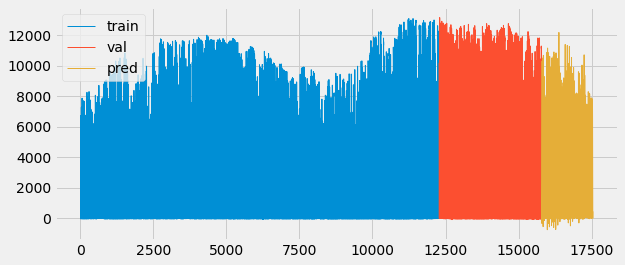

In [312]:
fig, ax = plt.subplots(figsize=(9, 4))
train.Solar.plot(ax=ax, label='train', linewidth=1)
val.Solar.plot(ax=ax, label='val', linewidth=1)
predictions.plot(ax=ax, label='pred', linewidth=1)
ax.legend()

In [314]:
# Error
error = mean_absolute_error(test.Solar, y_pred = predictions)
error_mse = mean_squared_error(test.Solar, y_pred = predictions)
print(f"Val Error: {error}, MSE error : {error_mse}")

Val Error: 1978.8684442954402, MSE error : 7579645.468182903
